# Verificação das hipóteses relacionadas a taxa de cancelamento

## Verificação das hipóteses 13

Hipótese 13: A porcentagem de cancelamento dos pedidos varia de acordo com o estado do endereço de entrega

### Definição dos dataframes utilizados

In [16]:
from pyspark.sql import SparkSession, functions as F
spark = SparkSession.builder.getOrCreate()

orders_df = spark.read \
                 .option('escape', '\"') \
                 .option('quote', '\"') \
                 .csv('./dataset/olist_orders_dataset.csv', header=True, multiLine=True, inferSchema=True)

customers_df = spark.read \
                  .option('escape', '\"') \
                  .option('quote', '\"') \
                  .csv('./dataset/olist_customers_dataset.csv', header=True, multiLine=True, inferSchema=True)

products_df = spark.read \
                  .option('escape', '\"') \
                  .option('quote', '\"') \
                  .csv('./dataset/olist_products_dataset.csv', header=True, multiLine=True, inferSchema=True)

items_df = spark.read \
                  .option('escape', '\"') \
                  .option('quote', '\"') \
                  .csv('./dataset/olist_order_items_dataset.csv', header=True, multiLine=True, inferSchema=True)

## Hipótese 13

### Definição do dataframe

In [28]:
df = orders_df.join(customers_df, orders_df.customer_id == customers_df.customer_id) \
                     .select('customer_state','order_delivered_customer_date','order_estimated_delivery_date')
df = df.filter(F.col('order_delivered_customer_date').isNotNull()) \
        .filter(F.col('order_estimated_delivery_date').isNotNull()) 

df.printSchema()

root
 |-- customer_state: string (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



### Contagem de pedidos por estados

In [9]:
df_all_orders = df.groupBy(F.col('customer_state')).count()
df_all_orders = df_all_orders.selectExpr('customer_state','count as all_orders_count')
df_all_orders.show()

+--------------+----------------+
|customer_state|all_orders_count|
+--------------+----------------+
|            SC|            3547|
|            RO|             243|
|            PI|             476|
|            AM|             145|
|            RR|              41|
|            GO|            1957|
|            TO|             274|
|            MT|             886|
|            SP|           40495|
|            ES|            1995|
|            PB|             517|
|            RS|            5344|
|            MS|             701|
|            AL|             397|
|            MG|           11355|
|            PA|             946|
|            BA|            3256|
|            SE|             335|
|            PE|            1593|
|            CE|            1279|
+--------------+----------------+
only showing top 20 rows



### Contagem de pedidos atrasados por estado

In [10]:
df_late = df.filter(F.col('order_delivered_customer_date') > F.col('order_estimated_delivery_date'))
df_late = df_late.groupBy(F.col('customer_state')).count()
df_late = df_late.selectExpr('customer_state','count as late_orders_count')
df_late.show()

+--------------+-----------------+
|customer_state|late_orders_count|
+--------------+-----------------+
|            SC|              346|
|            RO|                7|
|            PI|               76|
|            AM|                6|
|            RR|                5|
|            GO|              160|
|            TO|               35|
|            MT|               60|
|            SP|             2387|
|            ES|              244|
|            PB|               57|
|            RS|              382|
|            MS|               81|
|            AL|               95|
|            MG|              638|
|            PA|              117|
|            BA|              457|
|            SE|               51|
|            PE|              172|
|            CE|              196|
+--------------+-----------------+
only showing top 20 rows



### Calculo Porcentagem atrasados

In [11]:
df = df_late.join(df_all_orders, df_late.customer_state == df_all_orders.customer_state) \
    .select(df_late.customer_state,'late_orders_count','all_orders_count')

df = df.withColumn('percent_canceled', F.col('late_orders_count') / F.col('all_orders_count') *100) \
    .orderBy(F.desc('percent_canceled'))

df.show(50)

+--------------+-----------------+----------------+------------------+
|customer_state|late_orders_count|all_orders_count|  percent_canceled|
+--------------+-----------------+----------------+------------------+
|            AL|               95|             397|23.929471032745592|
|            MA|              141|             717|19.665271966527197|
|            PI|               76|             476|15.966386554621847|
|            CE|              196|            1279| 15.32447224394058|
|            SE|               51|             335|15.223880597014924|
|            BA|              457|            3256|14.035626535626536|
|            RJ|             1664|           12353|13.470412045656927|
|            TO|               35|             274|12.773722627737227|
|            PA|              117|             946|12.367864693446089|
|            ES|              244|            1995|12.230576441102757|
|            RR|                5|              41|12.195121951219512|
|     

### Exibição do gráfico

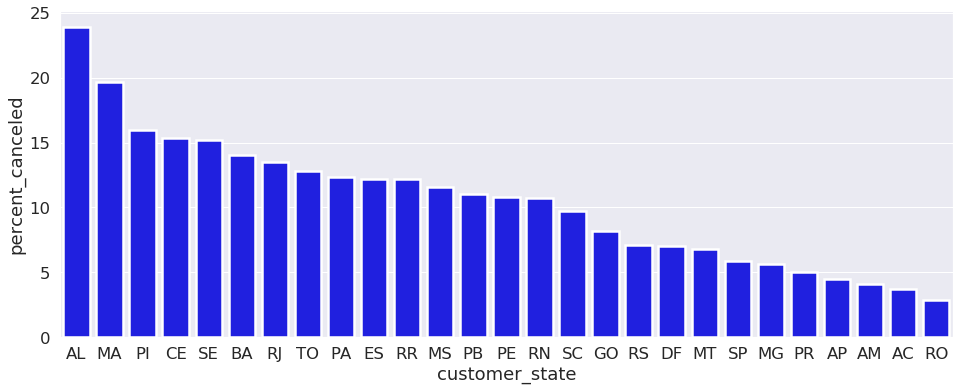

In [13]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 6))
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
ax = sns.barplot(x='customer_state', y='percent_canceled', data=df.toPandas(), color='blue', linewidth=2.5)

## Hipótese 14

### Definição do dataframe

In [29]:
df = items_df.join(products_df, items_df.product_id == products_df.product_id) \
             .join(orders_df, items_df.order_id == orders_df.order_id) \
             .select('product_category_name','order_delivered_customer_date','order_estimated_delivery_date')
df = df.filter(F.col('order_delivered_customer_date').isNotNull()) \
       .filter(F.col('order_estimated_delivery_date').isNotNull()) \
       .filter(F.col('product_category_name').isNotNull())

df.printSchema()

root
 |-- product_category_name: string (nullable = true)
 |-- order_delivered_customer_date: timestamp (nullable = true)
 |-- order_estimated_delivery_date: timestamp (nullable = true)



### Contagem de pedidos por categoria

In [31]:
df_all_orders = df.groupBy(F.col('product_category_name')).count()
df_all_orders = df_all_orders.selectExpr('product_category_name','count as all_orders_count')
df_all_orders.show()

+---------------------+----------------+
|product_category_name|all_orders_count|
+---------------------+----------------+
|                  pcs|             199|
|                bebes|            2982|
|                artes|             197|
|            cine_foto|              70|
|     moveis_decoracao|            8160|
|             pc_gamer|               8|
| construcao_ferram...|             916|
| tablets_impressao...|              83|
|    artigos_de_festas|              42|
| fashion_roupa_mas...|             125|
|     artigos_de_natal|             150|
|           la_cuisine|              14|
|               flores|              33|
|      livros_tecnicos|             263|
|       telefonia_fixa|             255|
| construcao_ferram...|             183|
|           cool_stuff|            3718|
|     eletrodomesticos|             754|
|    livros_importados|              57|
|             pet_shop|            1924|
+---------------------+----------------+
only showing top

### Contagem de pedidos atrasados por categoria

In [33]:
df_late = df.filter(F.col('order_delivered_customer_date') > F.col('order_estimated_delivery_date'))
df_late = df_late.groupBy(F.col('product_category_name')).count()
df_late = df_late.selectExpr('product_category_name','count as late_orders_count')
df_late.show()

+---------------------+-----------------+
|product_category_name|late_orders_count|
+---------------------+-----------------+
|                  pcs|               13|
|                bebes|              262|
|                artes|               15|
|            cine_foto|                5|
|     moveis_decoracao|              688|
| construcao_ferram...|               74|
| tablets_impressao...|                6|
| fashion_roupa_mas...|                7|
|    artigos_de_festas|                2|
|     artigos_de_natal|               18|
|               flores|                1|
|      livros_tecnicos|               29|
|       telefonia_fixa|               11|
| construcao_ferram...|               10|
|           cool_stuff|              251|
|     eletrodomesticos|               51|
|    livros_importados|                2|
|             pet_shop|              118|
|      casa_construcao|               49|
| livros_interesse_...|               35|
+---------------------+-----------

### Calculo Porcentagem atrasados

In [61]:
df = df_late.join(df_all_orders, df_late.product_category_name == df_all_orders.product_category_name) \
    .select(df_late.product_category_name,'late_orders_count','all_orders_count')

df = df.withColumn('percent_canceled', F.col('late_orders_count') / F.col('all_orders_count') *100) \
    .orderBy(F.desc('percent_canceled'))

df.show(70, truncate=False)

+----------------------------------------------+-----------------+----------------+------------------+
|product_category_name                         |late_orders_count|all_orders_count|percent_canceled  |
+----------------------------------------------+-----------------+----------------+------------------+
|casa_conforto_2                               |5                |30              |16.666666666666664|
|moveis_colchao_e_estofado                     |5                |37              |13.513513513513514|
|audio                                         |46               |362             |12.70718232044199 |
|fashion_underwear_e_moda_praia                |16               |127             |12.598425196850393|
|artigos_de_natal                              |18               |150             |12.0              |
|livros_tecnicos                               |29               |263             |11.02661596958175 |
|casa_conforto                                 |44               |429    

### Exibição do gráfico

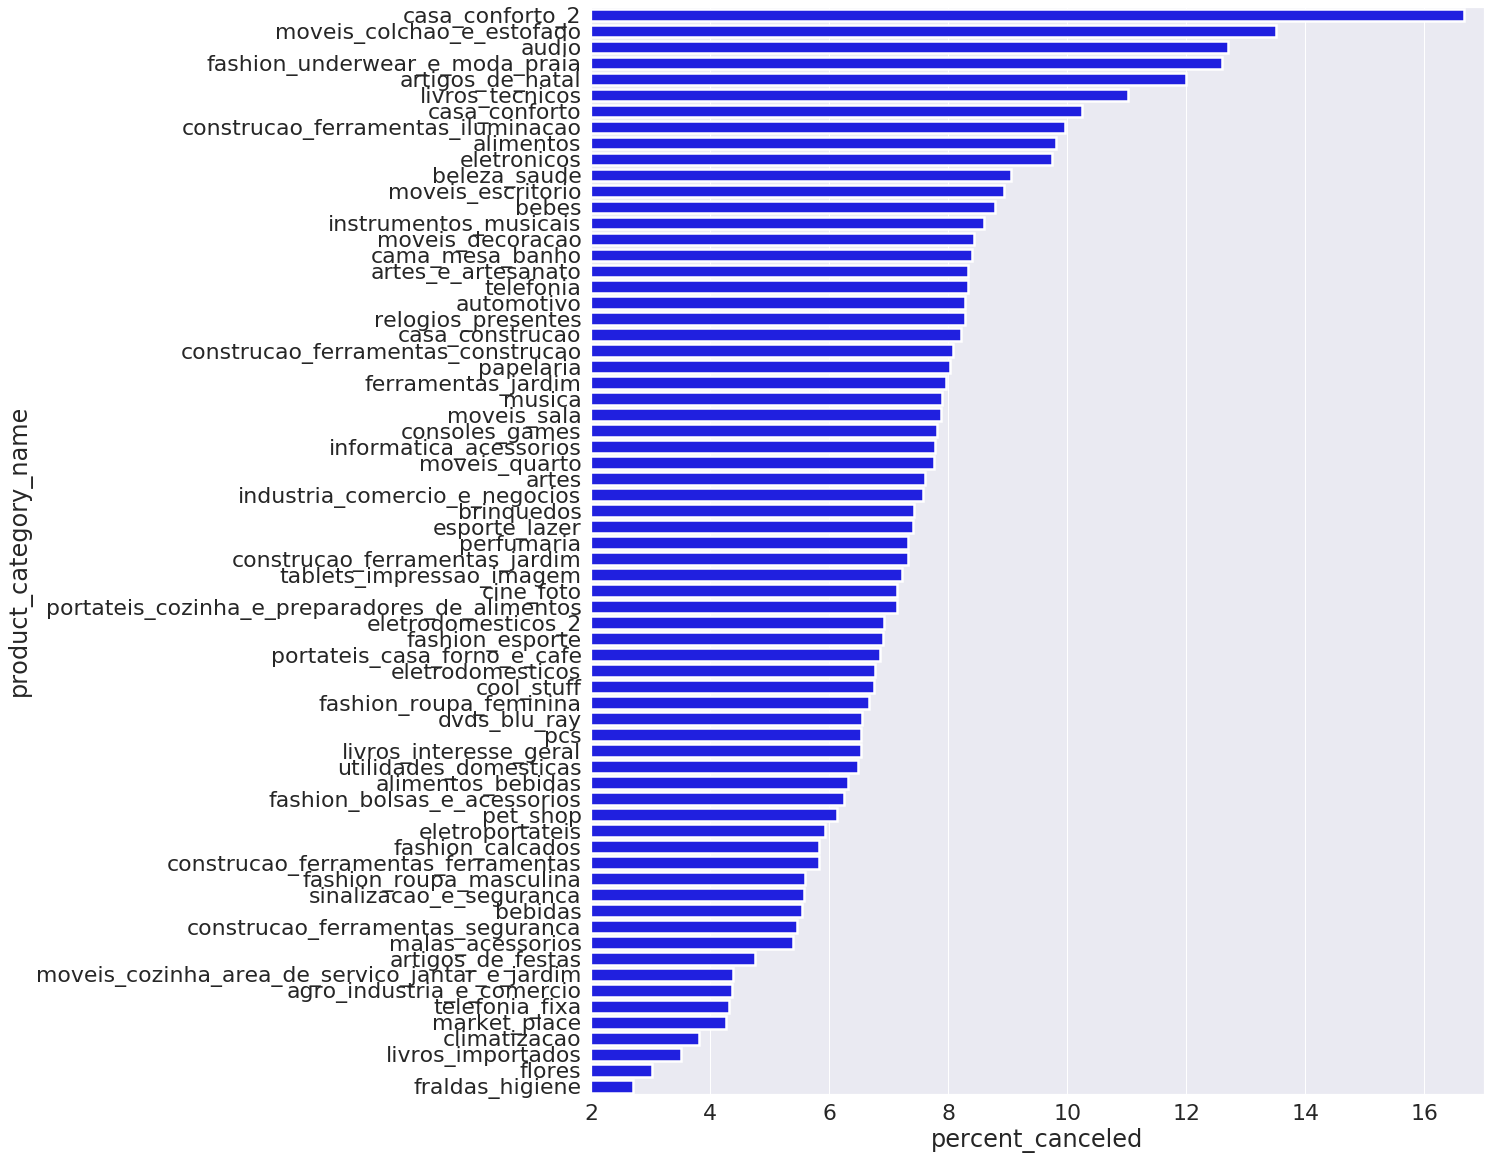

In [60]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
plt.figure(figsize=(16, 20))
plt.xlim(2, 17)
sns.set(style='whitegrid')
sns.set(font_scale=1.5)
ax = sns.barplot(x='percent_canceled', y='product_category_name', data=df.toPandas(), color='blue', linewidth=2.5)

## Conclusões

### A hipótese 13 é válida, pois a porcentagem de pedidos cancelados varia de acordo com a região, como por exemplo o estado de Alagoas tem uma taxa de cancelamento maior do que em outros estados

### A hipótese 14 foi cancelada devido a inconsistência dos dados em relação as categorias dos produtos